In [27]:
import torch
import numpy as np
from dataclasses import dataclass, field
from typing import List, Tuple
import matplotlib.pyplot as plt

@dataclass
class Configs:
    
    #...general params:
    WORKDIR : str = './'   
    DEVICE : str = 'cuda:0'
    MULTI_GPU : bool = False

    #...data params:
    DATA : str = None
    DATA_TARGET : str = 'Ngaussians'
    DATA_SOURCE : str = 'noise'
    DIM_CONTEXT : int = 0
    DIM_LABELS : int = 1
    INPUT_SHAPE : Tuple[float] = field(default_factory = lambda : (2, 1, 1))
    
    #...model params:
    MODEL : str = 'MLP'
    DIM_HIDDEN : int = 128  
    DIM_FEAT_EMB : int = 16
    DIM_TIME_EMB : int = 32
    DIM_CONTEXT_EMB : int = 0

    FEAT_ENCODING_TYPE : str = 'linear'      # None 'linear' 'kolmogorov-arnold'
    TIME_ENCODING_TYPE : str = 'kolmogorov-arnold'      # None 'linear' 'positional' 'randomfourier' 'kolmogorov-arnold'
    CONTEXT_ENCODING_TYPE : str = None                  # None 'linear' 'kolmogorov-arnold'

    NUM_LAYERS : int = 3
    DROPOUT : float = 0.0
    ACTIVATION : str = 'ReLU'

    #...training params:
    BATCH_SIZE : int = 128
    DATA_SPLIT_FRACS : List[float] = field(default_factory = lambda : [0.8, 0.2, 0.0])  # train / val / test 
    EPOCHS: int = 100
    EARLY_STOPPING : int = None
    MIN_EPOCHS : int = None 
    PRINT_EPOCHS : int = None   
    NUM_WORKERS : int = 0
    PIN_MEMORY: bool = False

    #...cfm params:
    DYNAMICS : str = 'CondFlowMatch'
    SIGMA : float = 0.001

    #...optimization & scheduler params:
    OPTIMIZER: str = 'Adam'
    LR : float = 1e-4
    WEIGHT_DECAY : float = 0.0
    OPTIMIZER_BETAS : List[float] = field(default_factory = lambda : [0.9, 0.999])
    OPTIMIZER_EPS : float = 1e-8
    OPTIMIZER_AMSGRAD : bool = False
    GRADIENT_CLIP : float = None
    SCHEDULER: str = None
    SCHEDULER_T_MAX: int = None
    SCHEDULER_ETA_MIN: float = None
    SCHEDULER_GAMMA: float = None
    SCHEDULER_STEP_SIZE: int = None

    #...generation pipeline params:
    SAMPLER : str = 'EulerSolver'
    SOLVER : str = 'euler'
    NUM_SAMPLING_STEPS : int = 200
    SENSITIVITY : str = 'adjoint'
    ATOL : float = None
    RTOL : float = None
    NUM_GEN_SAMPLES: int = 8000 


    def __post_init__(self):
        self.DATA = self.DATA_SOURCE + '_to_' + self.DATA_TARGET
        self.DIM_INPUT = np.prod(self.INPUT_SHAPE)
        if self.DIM_CONTEXT is None: self.DIM_CONTEXT = 0
        if self.MULTI_GPU: self.DEVICE = 'cuda:0'


def plot_trajectories(traj, labels=None, N=100000):
    """Plot trajectories of some selected samples."""
    plt.figure(figsize=(4, 4))
    for i in range(traj.shape[0]): 
        plt.scatter(traj[i, :N, 0], traj[i, :N, 1], s=.01, alpha=.05, c='gray' if labels is None else labels.unsqueeze(1)[:N], cmap='tab10')
    plt.scatter(traj[0, :N, 0], traj[0, :N, 1], s=1, alpha=1, c='b' if labels is None else labels.unsqueeze(1)[:N], cmap='tab10')
    plt.scatter(traj[-1, :N, 0], traj[-1, :N, 1], s=1, alpha=1, c= 'r' if labels is None else labels.unsqueeze(1)[:N], cmap='tab10')
    plt.xticks([])
    plt.yticks([])
    plt.axis('equal')
    plt.show()

# Data

In [28]:
from cmb.data.gaussians import EightGaussiansDataClass
from cmb.data.utils import DefineDataloader

conf = Configs()
gauss = EightGaussiansDataClass(conf, num_gaussians=8, num_points_per_gaussian=8000, std_dev=0.1)
dataloader = DefineDataloader(gauss)

INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 51200, validation size: 12800, testing sizes: 0


/tmp/ipykernel_2155886/1315795329.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(gauss.target[:, 0], gauss.target[:, 1], s=1, c=gauss.context if conf.DIM_CONTEXT else 'r', cmap = 'tab10')
/tmp/ipykernel_2155886/1315795329.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(gauss.source[:, 0], gauss.source[:, 1], s=1, c=gauss.context if conf.DIM_CONTEXT else 'b', cmap = 'tab10')


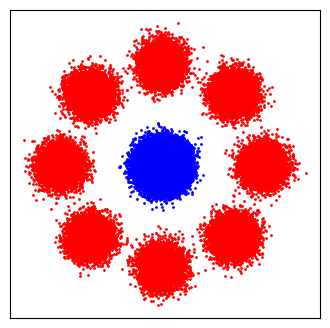

In [3]:
gauss.target.shape
plt.figure(figsize=(4, 4))
plt.scatter(gauss.target[:, 0], gauss.target[:, 1], s=1, c=gauss.context if conf.DIM_CONTEXT else 'r', cmap = 'tab10')
plt.scatter(gauss.source[:, 0], gauss.source[:, 1], s=1, c=gauss.context if conf.DIM_CONTEXT else 'b', cmap = 'tab10')
plt.xticks([])
plt.yticks([])
plt.axis('equal')
plt.show()

# Flow-Matching with MLP

We try out various time/position encodings

In [29]:
from cmb.dynamics.cfm import ConditionalFlowMatching
from cmb.models.architectures.deep_nets import MLP
from cmb.models.trainers import CMBTrainer

dynamics = ConditionalFlowMatching(conf)
mlp = MLP(conf)
model = CMBTrainer(dynamics, mlp, gauss)
model.train()

number of training parameters: 24978
number of training parameters: 24978
start training...
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 51200, validation size: 12800, testing sizes: 0


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

### 1. MLP with sinusoidal time encoding and linear position encoding

INFO: EulerSolver with euler method and steps=200


/tmp/ipykernel_2196170/3586324857.py:87: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[i, :N, 0], traj[i, :N, 1], s=.01, alpha=.05, c='gray' if labels is None else labels.unsqueeze(1)[:N], cmap='tab10')
/tmp/ipykernel_2196170/3586324857.py:88: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[0, :N, 0], traj[0, :N, 1], s=1, alpha=1, c='b' if labels is None else labels.unsqueeze(1)[:N], cmap='tab10')
/tmp/ipykernel_2196170/3586324857.py:89: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[-1, :N, 0], traj[-1, :N, 1], s=1, alpha=1, c= 'r' if labels is None else labels.unsqueeze(1)[:N], cmap='tab10')


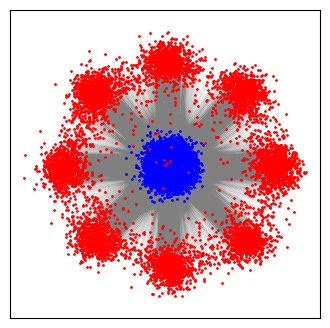

In [24]:
from cmb.models.pipelines import CFMPipeline

input_source = torch.randn(8000, 2) * 0.1

pipeline = CFMPipeline(trained_model=model, config=conf)
pipeline.generate_samples(input_source)
plot_trajectories(pipeline.trajectories)

### 2. MLP with "Kolmogorov-Arnold" time encoding and linear position encoding

INFO: EulerSolver with euler method and steps=200


/tmp/ipykernel_2196170/522399337.py:87: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[i, :N, 0], traj[i, :N, 1], s=.01, alpha=.05, c='gray' if labels is None else labels.unsqueeze(1)[:N], cmap='tab10')
/tmp/ipykernel_2196170/522399337.py:88: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[0, :N, 0], traj[0, :N, 1], s=1, alpha=1, c='b' if labels is None else labels.unsqueeze(1)[:N], cmap='tab10')
/tmp/ipykernel_2196170/522399337.py:89: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[-1, :N, 0], traj[-1, :N, 1], s=1, alpha=1, c= 'r' if labels is None else labels.unsqueeze(1)[:N], cmap='tab10')


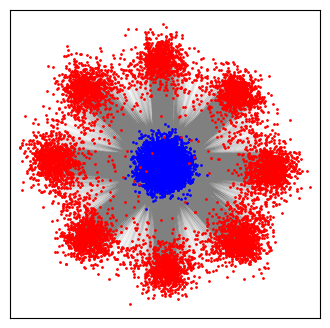

In [30]:
from cmb.models.pipelines import CFMPipeline

input_source = torch.randn(8000, 2) * 0.1

pipeline = CFMPipeline(trained_model=model, config=conf)
pipeline.generate_samples(input_source)
plot_trajectories(pipeline.trajectories)

### 3. MLP with "Kolmogorov-Arnold" encoding for time & position

INFO: EulerSolver with euler method and steps=200


/tmp/ipykernel_2196170/2497016852.py:87: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[i, :N, 0], traj[i, :N, 1], s=.01, alpha=.05, c='gray' if labels is None else labels.unsqueeze(1)[:N], cmap='tab10')
/tmp/ipykernel_2196170/2497016852.py:88: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[0, :N, 0], traj[0, :N, 1], s=1, alpha=1, c='b' if labels is None else labels.unsqueeze(1)[:N], cmap='tab10')
/tmp/ipykernel_2196170/2497016852.py:89: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[-1, :N, 0], traj[-1, :N, 1], s=1, alpha=1, c= 'r' if labels is None else labels.unsqueeze(1)[:N], cmap='tab10')


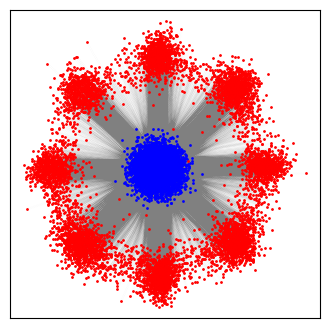

In [20]:
from cmb.models.pipelines import CFMPipeline

input_source = torch.randn(8000, 2) * 0.1

pipeline = CFMPipeline(trained_model=model, config=conf)
pipeline.generate_samples(input_source)
plot_trajectories(pipeline.trajectories)

# Flow-matching with Kolmogorov-Arnold Network 

In [3]:
from cmb.dynamics.cfm import ConditionalFlowMatching
from cmb.models.architectures.deep_nets import KolmogorovArnoldNetwork
from cmb.models.trainers import CMBTrainer

dynamics = ConditionalFlowMatching(conf)
kan = KolmogorovArnoldNetwork(conf)
model = CMBTrainer(dynamics, kan, gauss)
model.train()

2024-08-23 20:03:38.605219: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-23 20:03:38.643137: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-23 20:03:38.643874: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-23 20:03:39.298792: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
number of training parameters: 22386
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 51200, validation size: 12800, testing sizes: 0


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: EulerSolver with euler method and steps=200


/tmp/ipykernel_2185924/944628600.py:81: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[i, :N, 0], traj[i, :N, 1], s=.01, alpha=.05, c='gray' if labels is None else labels.unsqueeze(1)[:N], cmap='tab10')
/tmp/ipykernel_2185924/944628600.py:82: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[0, :N, 0], traj[0, :N, 1], s=1, alpha=1, c='b' if labels is None else labels.unsqueeze(1)[:N], cmap='tab10')
/tmp/ipykernel_2185924/944628600.py:83: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[-1, :N, 0], traj[-1, :N, 1], s=1, alpha=1, c= 'r' if labels is None else labels.unsqueeze(1)[:N], cmap='tab10')


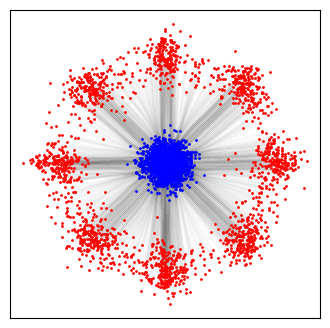

In [4]:
from cmb.models.pipelines import CFMPipeline

input_source = torch.randn(4000, 2) * 0.1

pipeline = CFMPipeline(trained_model=model, config=conf)
pipeline.generate_samples(input_source)
plot_trajectories(pipeline.trajectories, N=2000)